# Extracting Features D2V

### Setup

In [1]:
%run -i 'random_state.py'
from packages import *
from clean_functions import *
from tokenizer import *

Using TensorFlow backend.


### Loading D2V model

In [2]:
doc = Doc2Vec.load("models/doc2vec_mov_100_10")  

In [3]:
embed_dim=doc['juiz'].shape[0]
embed_dim

100

### Preparing datasets

In [4]:
with open("data/mov.txt", "rb") as fp:   # Legal proceedings
    mov = pickle.load(fp)

with open("data/tags.txt", "rb") as fp:   # Tags
    tags = pickle.load(fp)

Letting motions in cronological order:

In [5]:
mov[0][:4]

[['14-11-2018',
  'Tipo do Movimento:Ato Ordinatório Praticado Descrição:Certifico e dou fé que as custas pendentes de fls 685 não foram recolhidas pelas parte GILMAR RODRIGUES REGO e BRUNO MEDEIROS.'],
 ['23-07-2018',
  'Tipo do Movimento:Juntada - Petição Descrição da juntada:Documento eletrônico juntado de forma automática.'],
 ['16-07-2018',
  'Tipo do Movimento:Publicado\xa0 Atos da Serventia Folhas do DJERJ.:388/416'],
 ['29-06-2018', 'Tipo do Movimento:Enviado para publicação ']]

In [6]:
for m in mov:
    m.reverse()

In [7]:
mov[0][:4]

[['10-09-2010',
  'Tipo do Movimento:Distribuição Sorteio Serventia:Cartório da 34ª Vara Cível - 34ª Vara Cível'],
 ['21-09-2010',
  'Tipo do Movimento:Conclusão ao Juiz Juiz:JOAO MARCOS DE CASTELLO BRANCO FANTINATO'],
 ['23-09-2010',
  'Tipo do Movimento:Despacho - Proferido despacho de mero expediente Descrição:Defiro JG. \r\n\r\nIndefiro a antecipação dos efeitos da tutela, eis que as alegações do autor carecem de dilação probatória.\r\n\r\nCite-se.'],
 ['23-09-2010', 'Tipo do Movimento:Enviado para publicação ']]

Cleaning texts

In [8]:
%%time

for i in range(len(mov)):
    for j in range(len(mov[i])):
        mov[i][j][1]=clean(mov[i][j][1])

CPU times: user 42.1 s, sys: 34.7 ms, total: 42.2 s
Wall time: 42.2 s


### Defining some functions

In [9]:
#Embedding function
def emb_d2v(tokens, model, normalize=False): 
    
    model.random.seed(random_seed)
    x=model.infer_vector(tokens, steps=30)
    
    if normalize: return(x/(np.sqrt(x@x)))
    else: return(x)

#function to get X and y
def get_X_y_d2v(mov,tags,len1=5):
    
    #len1: let's take the last l1 motions in each proceeding
    
    #indexes of valid legal proceedings (with motions and tags)
    index=[]
    for i in range(len(mov)):
        if 0<len(mov[i]) and tags[i]!="": index.append(i) 
        else: pass

    print("Number of valid proceedings (with motions and tags):",len(index),"\n")

    #organizing motions in X and tags in y
    X=np.zeros((len(index),len1,embed_dim))
    y=[]
    cont=0
    
    #get numerical X embedding the tokens from those motions (from valid proceedings):
    for i in index:
        temp=[]
        y.append(tags[i])

        mov[i]=mov[i][-len1::] #let's take the last l1 motions in each proceeding

        for j in range(len(mov[i])):
            temp=emb_d2v(tokenizer(mov[i][j][1]), doc)
            X[cont][j][:np.shape(temp)[0]]=temp

        #counter
        cont+=1
        if cont%int(len(index)/5)==0: print(round(100*cont/len(index),0),"% concluded")
        else: pass
        
    return X,y

### Exploring data

Let's evaluate the distribution of motion quantities per proceeding.

In [10]:
%%time

leng1=[]
for i in range(len(mov)):
    leng1.append(len(mov[i]))

CPU times: user 3.23 ms, sys: 0 ns, total: 3.23 ms
Wall time: 3.24 ms


In [11]:
%%time

dist1=[]
leng1=np.array(leng1)

for i in range(300):
    dist1.append([i,np.mean(leng1<=i)])
    
dist1=np.array(dist1)

CPU times: user 11.3 ms, sys: 0 ns, total: 11.3 ms
Wall time: 11 ms


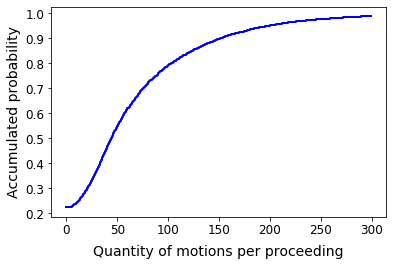

In [12]:
plt.step(dist1[:,0],dist1[:,1],color='blue', linewidth=2)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Accumulated probability', size=14)
plt.xlabel('Quantity of motions per proceeding', fontsize=14, labelpad=8)
plt.gcf().subplots_adjust(bottom=0.15)
plt.savefig("plots/dist_mov.png", facecolor='white', dpi=100)
plt.show()

### Getting the data and saving it

In [ ]:
%%time

len1=5 #vamos pegar somente as últimas len1 movimentações

X,y=get_X_y_d2v(mov,tags,len1)

Number of valid proceedings (with motions and tags): 6449 

20.0 % concluded


In [ ]:
X.shape

Saving data

In [ ]:
np.save('data/X_d2v.npy', X)
np.save('data/y_d2v.npy', y)